# BIM Production

We consider Caroline's material planning again, but now with more sophisticated pricing and acquisition protocols. 
There are now three suppliers. 
The suppliers can deliver the following materials:
 - A: **silicon**, **germanium** and **plastic**
 - B: **copper**
 - C: all of the above
Copper should be acquired in multiples of 100 gram, since it is delivered in sheets of 100 gram. 
Unitary materials such as silicon, germanium and plastic may be acquired in any number, but the price is in batches of 100. Meaning that 30 units of silicon with 10 units of germanium and 50 units of plastic cost as much as 1 unit of silicon but half as much as 30 units of silicon with 30 units of germanium and 50 units of plastic. 
Furthermore, supplier C sells all materials and offers a discount if purchased together: 100 gram of copper and a batch of unitary material cost just 7. This set price is only applied to pairs, meaning that 100 gram of copper and 2 batches cost 13.

The prices are as follows in &euro;:

|Supplier|Copper per sheet of 100 gram|Batch of units|Together|
|:-------|---------------------:|-----------------:|-------:|
| A      |                    - |                5 |      - |
| B      |                    3 |                - |      - |
| C      |                    4 |                6 |      7 |

When stocking materials, the inventory costs are as follows per month:

|Copper per 10 gram| Silicon per unit| Germanium per unit|Plastic per unit|
|---:|-------:|---:|-----:|
| 0.1|   0.02 |0.02| 0.02 |

The holding price of copper is per 10 gram and the copper stocked is rounded up to multiples of 10 grams, meaning that 12 grams pay for 20. 

The capacity limitations of the warehouse allow for a maximum of 10 kilogram of copper in stock at any moment.
There are no practical limitations to the number of units in stock.

As you recall, Caroline has the following stock at the moment:

|Copper |Silicon |Germanium |Plastic|
|---:|-------:|---:|-----:|
| 480|   1000 |1500| 1750 |

Caroline would like to have at least the following stock at the end of the year:

|Copper |Silicon |Germanium |Plastic|
|---:|-------:|---:|-----:|
| 200|    500 | 500| 1000 |

Please help her to model the material planning and solve it with the data above. 
Note that Caroline aims at minimizing the acquisition and holding costs of the materials while meeting the required quantities for production. 
The production is made to order, meaning that no inventory of chips is kept.


In [1]:
import sys
if 'google.colab' in sys.modules:
    import shutil
    if not shutil.which('pyomo'):
        !pip install -q pyomo
        assert(shutil.which('pyomo'))

    # cbc
    !apt-get install -y -qq coinor-cbc

To be self contained... alternative is to upload and read a file. 

In [2]:
demand_data = '''chip,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
Logic,88,125,260,217,238,286,248,238,265,293,259,244
Memory,47,62,81,65,95,118,86,89,82,82,84,66'''

In [3]:
from io import StringIO
import pandas as pd
demand_chips = pd.read_csv( StringIO(demand_data), index_col='chip' )
demand_chips

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
chip,,,,,,,,,,,,
Logic,88,125,260,217,238,286,248,238,265,293,259,244
Memory,47,62,81,65,95,118,86,89,82,82,84,66


In [4]:
use = dict()
use['Logic'] = { 'silicon' : 1, 'plastic' : 1, 'copper' : 4 }
use['Memory'] = { 'germanium' : 1, 'plastic' : 1, 'copper' : 2 }
use = pd.DataFrame.from_dict( use ).fillna(0).astype( int )
use

,Logic,Memory
silicon,1,0
plastic,1,1
copper,4,2
germanium,0,1


In [5]:
demand = use.dot( demand_chips )
demand

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
silicon,88,125,260,217,238,286,248,238,265,293,259,244
plastic,135,187,341,282,333,404,334,327,347,375,343,310
copper,446,624,1202,998,1142,1380,1164,1130,1224,1336,1204,1108
germanium,47,62,81,65,95,118,86,89,82,82,84,66


## DONE
 - the example has been changed to follow the BIM story
 - checked that it solves
 
## TODO: 
 - still need to describe the modeling choices.
 - still need to adjust the code to meet the style guide

In [6]:
import pyomo.environ as pyo

m = pyo.ConcreteModel("Francis' material planning")  

m.periods = demand.keys()
m.materials = demand.index

In [7]:
m.existing = {'silicon' : 1000, 'germanium': 1500, 'plastic': 1750, 'copper' : 4800 }
m.desired  = {'silicon' :  500, 'germanium':  500, 'plastic': 1000, 'copper' : 2000 }

In [8]:
m.suppliers        = ['A','B','C']
m.supplyingPoles   = [ 'B', 'C' ]
m.supplyingBatches = [ 'A', 'C' ]
m.givingDiscount   = [ 'C' ]

# we express prices in cents to preserve integers
m.priceBatch = { 'A': 500, 'C': 600 }
m.pricePole  = { 'B': 300, 'C': 400 }
m.discount   = m.priceBatch['C']+m.pricePole['C']-700

m.batchSize = 100

m.unitaryHoldingCosts = { 'copper': 10, 'silicon' : 2, 'germanium': 2, 'plastic': 2 }
m.unitaryMaterials = [ 'silicon', 'germanium', 'plastic' ]

In [9]:
m.stock     = pyo.Var( m.materials, m.periods, within=pyo.NonNegativeReals )
m.buy       = pyo.Var( m.supplyingBatches, m.unitaryMaterials, m.periods, within=pyo.NonNegativeReals )
m.batches   = pyo.Var( m.supplyingBatches, m.periods, within=pyo.NonNegativeIntegers )
m.poles     = pyo.Var( m.supplyingPoles, m.periods, within=pyo.NonNegativeIntegers )
m.pairs     = pyo.Var( m.periods, within=pyo.NonNegativeIntegers )
m.meters    = pyo.Var( m.periods, within=pyo.NonNegativeIntegers )

m.obj = pyo.Objective( expr = sum( m.priceBatch[b] * m.batches[b,i] for b in m.supplyingBatches for i in m.periods )        \
                            + sum( m.pricePole[p] * m.poles[p,i] for p in m.supplyingPoles for i in m.periods )             \
                            - sum( m.discount * m.pairs[i] for i in m.periods )                                                 \
                            + sum( m.unitaryHoldingCosts['copper'] * m.meters[i] for i in m.periods )                             \
                            + sum( m.unitaryHoldingCosts[j] * m.stock[j,i] for j in m.unitaryMaterials for i in m.periods ) \
                     , sense = pyo.minimize
                     )

def PairsInBatches( m, i ):
    return m.pairs[i] <= m.batches['C',i]    
def PairsInPoles( m, i ):
    return m.pairs[i] <= m.poles['C',i]    

m.pairsInBatches = pyo.Constraint( m.periods, rule = PairsInBatches )
m.pairsInPoles   = pyo.Constraint( m.periods, rule = PairsInPoles )

def WoodStock( m, i ):
    return m.stock['copper',i] <= 10*m.meters[i]
def WoodStockMax( m, i ):
    return m.stock['copper',i] <= 10000
def InBatches( m, i, b ):
    return sum( m.buy[b,j,i] for j in m.unitaryMaterials ) <= m.batchSize*m.batches[b,i]

m.woodStock      = pyo.Constraint( m.periods, rule = WoodStock )
m.woodStockMax   = pyo.Constraint( m.periods, rule = WoodStockMax )
m.inBatches      = pyo.Constraint( m.periods, m.supplyingBatches, rule = InBatches )

m.constraints = pyo.ConstraintList()  # Create a set of constraints

first = m.periods[0]
last  = m.periods[-1]

for j in m.unitaryMaterials:
    m.constraints.add( m.stock[j,first] == m.existing[j] + sum(m.buy[b,j,first] for b in m.supplyingBatches) - demand.loc[j,first] )
    for prev,current in zip(m.periods,m.periods[1:]):
        m.constraints.add( m.stock[j,current] == m.stock[j,prev] + sum(m.buy[b,j,current] for b in m.supplyingBatches) - demand.loc[j,current] )
    m.constraints.add( m.stock[j,last] >= m.desired[j] )
    
m.constraints.add( m.stock['copper',first] == m.existing['copper'] + 100*sum(m.poles[p,first] for p in m.supplyingPoles) - demand.loc['copper',first] )
for prev,current in zip(m.periods,m.periods[1:]):
    m.constraints.add( m.stock['copper',current] == m.stock['copper',prev] + 100*sum(m.poles[p,current] for p in m.supplyingPoles) - demand.loc['copper',current] )
m.constraints.add( m.stock['copper',last] >= m.desired['copper'] )

%time results = pyo.SolverFactory('gurobi_direct').solve(m)

CPU times: total: 93.8 ms
Wall time: 148 ms


In [10]:
results

{'Problem': [{'Name': '"Francis\' material planning"', 'Lower bound': 110216.00000000012, 'Upper bound': 110216.00000000012, 'Number of objectives': 1, 'Number of constraints': 124, 'Number of variables': 192, 'Number of binary variables': 0, 'Number of integer variables': 72, 'Number of continuous variables': 120, 'Number of nonzeros': 372, 'Sense': 1, 'Number of solutions': 7}], 'Solver': [{'Name': 'Gurobi 9.50', 'Status': 'ok', 'Wallclock time': 0.030946731567382812, 'Termination condition': 'optimal', 'Termination message': 'Model was solved to optimality (subject to tolerances), and an optimal solution is available.'}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

In [22]:
if  results.solver.termination_condition == 'optimal':
    import numpy as np
    np.set_printoptions(edgeitems=3,infstr='inf',linewidth=200, nanstr='nan', precision=15, suppress=False, threshold=1000, formatter=None)
    value   = m.obj.expr()
    Batches = [ [ m.batches[b,i].value for i in m.periods ] for b in m.supplyingBatches ]
    Poles   = [ [ m.poles[b,i].value for i in m.periods ] for b in m.supplyingPoles ]
    Pairs   = [ m.pairs[i].value for i in m.periods ] 
    Buy     = [ [ [ m.buy[s,j,i].value for i in m.periods ] for j in m.unitaryMaterials ] for s in m.supplyingBatches ]
    Stock   = [ [ m.stock[j,i].value for i in m.periods ] for j in m.materials ]
    Meters  = [ m.meters[i].value for i in m.periods ]
    
    def months( before='', after='', length=5 ):
        return ''.join( ['{:>{l}s}'.format(before,l=length)] + [ '{:>{l}s}'.format(j,l=length) for j in calendar.month_abbr[1:] + ['{:>{l}s}'.format(after,l=length)] ] )
        
    def describe( list, decimals=0 ):
        formattedList = [ '{:5.{prec}f}'.format( member + 0, prec=decimals ) for member in list]
        return ''.join(formattedList)
        
    print('')
    print( 'Costs : ', np.around( value/100, 3 ) )
    print('')
    print( '{:>13s}'.format('periods') + ''.join( [ '{:>{l}s}'.format(p,l=5) for p in m.periods ] ) )
    
    print( 'buy')
    for s,supplier in enumerate(m.supplyingBatches):
        print(supplier)
        for i,j in enumerate(m.unitaryMaterials):
            print('{:>13s}'.format(j) + describe( Buy[s][i] ) )
    print( 'batches')
    for s,supplier in enumerate(m.supplyingBatches):
        print('{:>13s}'.format(supplier) + describe( Batches[s] ) )
    print( 'poles' )
    for s,supplier in enumerate(m.supplyingPoles):
        print('{:>13s}'.format(supplier) + describe( Poles[s] ) )
        
    print( '' )
    print('{:>13s}'.format('pairs from C') + describe( Pairs ) )
    print( '' )
            
    import calendar 
    print( 'stock')
    print( '{:>12s}'.format('material') + months( before='from', after='to') )
    for i,j in enumerate(m.materials):
        print( '{:>12s}'.format(j) + describe( [m.existing[j]] + Stock[i] + [m.desired[j]] ) )
       
    print( '' )
    print('{:>17s}'.format('full copper meters') + describe( Meters ) )


Costs :  1102.16

      periods  Jan  Feb  Mar  Apr  May  Jun  Jul  Aug  Sep  Oct  Nov  Dec
buy
A
      silicon    0    0    0    0    0    0    0    0    0    0    0    0
    germanium    0    0    0    0    0    0    0    0    0    0    0    0
      plastic    0    0    0    0    0    0    0    0    0    0    0    0
C
      silicon    0    0    0    0    0  214  248  274  253  325  203  744
    germanium    0    0    0    0    0    0    0    0    0    0    0    0
      plastic    0    0    0    0    0   15  252  326  347  375  397 1256
batches
            A    0    0    0    0    0    0    0    0    0    0    0    0
            C    0    0    0    0    0    3    5    6    6    7    6   20
poles
            B    0    0    0    0    0    7    7    5    7    6    6   11
            C    0    0    0    0    0    3    5    6    6    7    6   20

 pairs from C    0    0    0    0    0    3    5    6    6    7    6   20

stock
    material from  Jan  Feb  Mar  Apr  May  Jun  Jul  Aug  Sep 

## Tabular variables are ideal for dataframes

In [23]:
def ShowTriple( X, I,J,K, names ):
    index = pd.MultiIndex.from_product([I,J], names=names)
    return pd.DataFrame.from_records( [ [ X[i,j,k].value for k in K ] for i in I for j in J ],index=index,columns=K )
def ShowDouble( X, I,J ):
    return pd.DataFrame.from_records( [ [ X[i,j].value for j in J ] for i in I ], index=I, columns=J )
def ShowSingle( X, I ):
    return pd.DataFrame( [ X[i].value for i in I ], index=I ).T

In [24]:
ShowTriple( m.buy, m.supplyingBatches, m.unitaryMaterials, m.periods, ['supplier','materials'] ).astype(int)

Jan  Feb  Mar  Apr  May  Jun  Jul  Aug  Sep  Oct  Nov  \
supplier materials                                                          
A        silicon      0    0    0    0    0    0    0    0    0    0    0   
         germanium    0    0    0    0    0    0    0    0    0    0    0   
         plastic      0    0    0    0    0    0    0    0    0    0    0   
C        silicon      0    0    0    0    0  213  248  273  253  325  203   
         germanium    0    0    0    0    0    0    0    0    0    0    0   
         plastic      0    0    0    0    0   15  251  326  347  375  396   

                     Dec  
supplier materials        
A        silicon       0  
         germanium     0  
         plastic       0  
C        silicon     744  
         germanium     0  
         plastic    1256

In [25]:
ShowDouble( m.stock, m.materials, m.periods ).astype(int)

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
silicon,912,787,527,310,72,0,0,35,23,55,0,500
plastic,1615,1428,1087,805,472,83,0,0,0,0,53,999
copper,4354,3730,2528,1530,388,8,44,14,90,54,50,2042
germanium,1453,1391,1310,1245,1150,1032,946,857,775,693,609,543


In [26]:
ShowDouble( m.batches, m.supplyingBatches, m.periods ).astype(int)

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
A,0,0,0,0,0,0,0,0,0,0,0,0
C,0,0,0,0,0,3,5,6,6,7,6,20


In [27]:
ShowDouble( m.poles, m.supplyingPoles, m.periods ).astype(int)

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
B,0,0,0,0,0,7,7,5,7,6,6,11
C,0,0,0,0,0,3,5,6,6,7,6,20


In [28]:
ShowSingle( m.pairs, m.periods ).astype(int)

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,0,0,0,0,0,3,5,6,6,7,6,20


In [29]:
ShowSingle( m.meters, m.periods ).astype(int)

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,436,373,253,153,39,1,5,2,9,6,5,205


## Dataframes come with a wealth of ready made graphics

In [30]:
stock = ShowDouble( m.stock, m.materials, m.periods ).astype(int).T
%matplotlib inline
import matplotlib.pyplot as plt

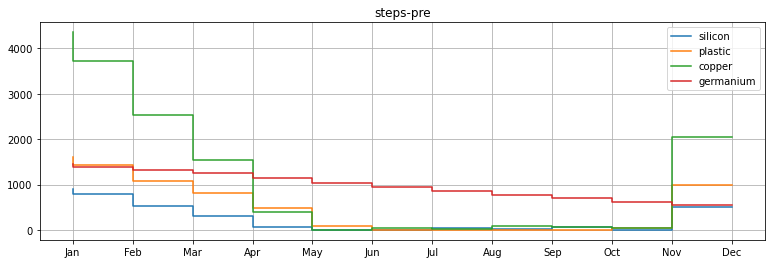

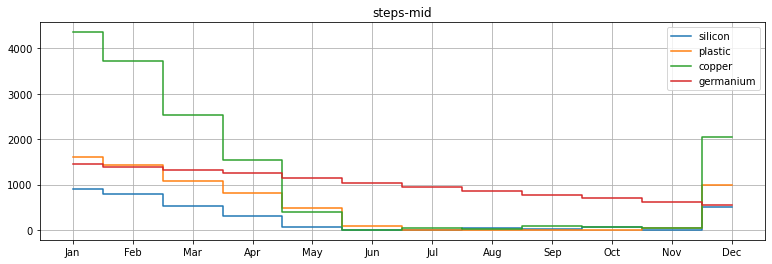

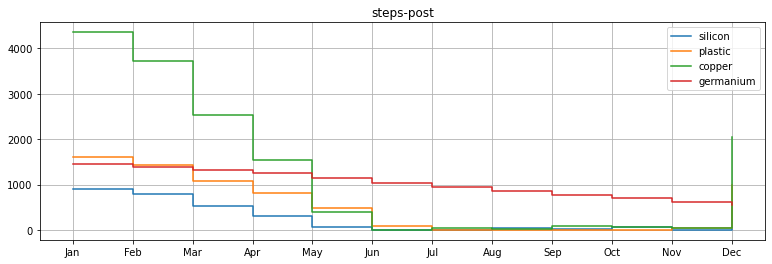

In [31]:
steps = ['pre','mid','post']
for s in steps:
  step = 'steps-'+s
  ax = stock.plot(drawstyle=step,grid=True, figsize=(13,4), title=step)
  ax.set_xticks(range(len(stock.index)))
  ax.set_xticklabels(stock.index)
  plt.show()

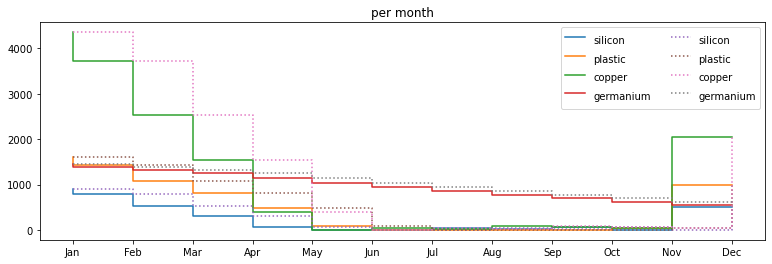

In [32]:
ax = stock.plot(drawstyle='steps-'+steps[0],figsize=(13,4), title='per month')
ax.set_xticks(range(len(stock.index)))
ax.set_xticklabels(stock.index)
for s in steps[-1:]:
  step = 'steps-'+s
  stock.plot(ax=ax,drawstyle=step, ls=':')
plt.legend(ncol=2,handleheight=2.4, labelspacing=0.05)
plt.show()